In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
        # print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from tensorflow import keras
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style= "darkgrid", color_codes = True)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Conv2DTranspose, Reshape, BatchNormalization, Dropout, Input, ReLU, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

2025-06-20 12:18:43.391801: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750421923.608931      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750421923.661923      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Loading and Preparing Anime Face Images Dataset using Keras Image Data Generator
img_width, img_height = 256, 256
batchsize = 32

train = keras. utils.image_dataset_from_directory(
    directory='/kaggle/input/animefacedataset',
    batch_size = batchsize,
    image_size = (img_width, img_height))

Found 63565 files belonging to 1 classes.


I0000 00:00:1750422009.907535      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


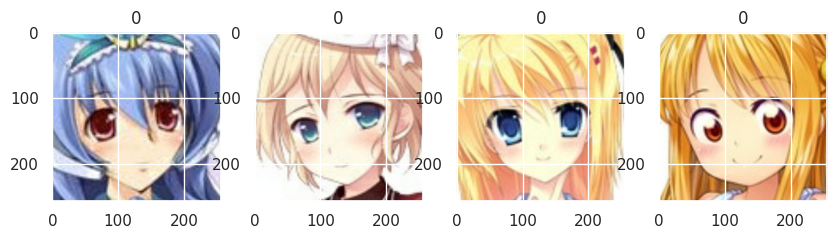

In [4]:
# Visualizing a Batch of Anime Face Images

data_iterator = train.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(ncols=4, figsize=(10,10))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [5]:
# Generating Augmented Batches of Anime Face Images using ImageDataGenerator
DIR = '/kaggle/input/animefacedataset' #path

# Create an ImageDataGenerator object with data augmentation options for image preprocessing
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip = True)

train_generator = train_datagen.flow_from_directory(
        DIR,
        target_size = (64, 64),
        batch_size = batchsize,
        class_mode = None)

#train_generator[0]

Found 63565 images belonging to 1 classes.


#### The Generator

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                      │ (None, 32768)               │       9,863,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_4 (Reshape)                  │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_20                  │ (None, 16, 16, 256)         │       2,097,408 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_21                  │ (None, 32, 32, 128)         │         524,416 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_22                  │ (None, 64, 64, 64)          │         131,136 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 64, 64, 3)           │           3,075 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,619,203 (48.14 MB)

 Trainable params: 12,619,203 (48.14 MB)

 Non-trainable params: 0 (0.00 B)

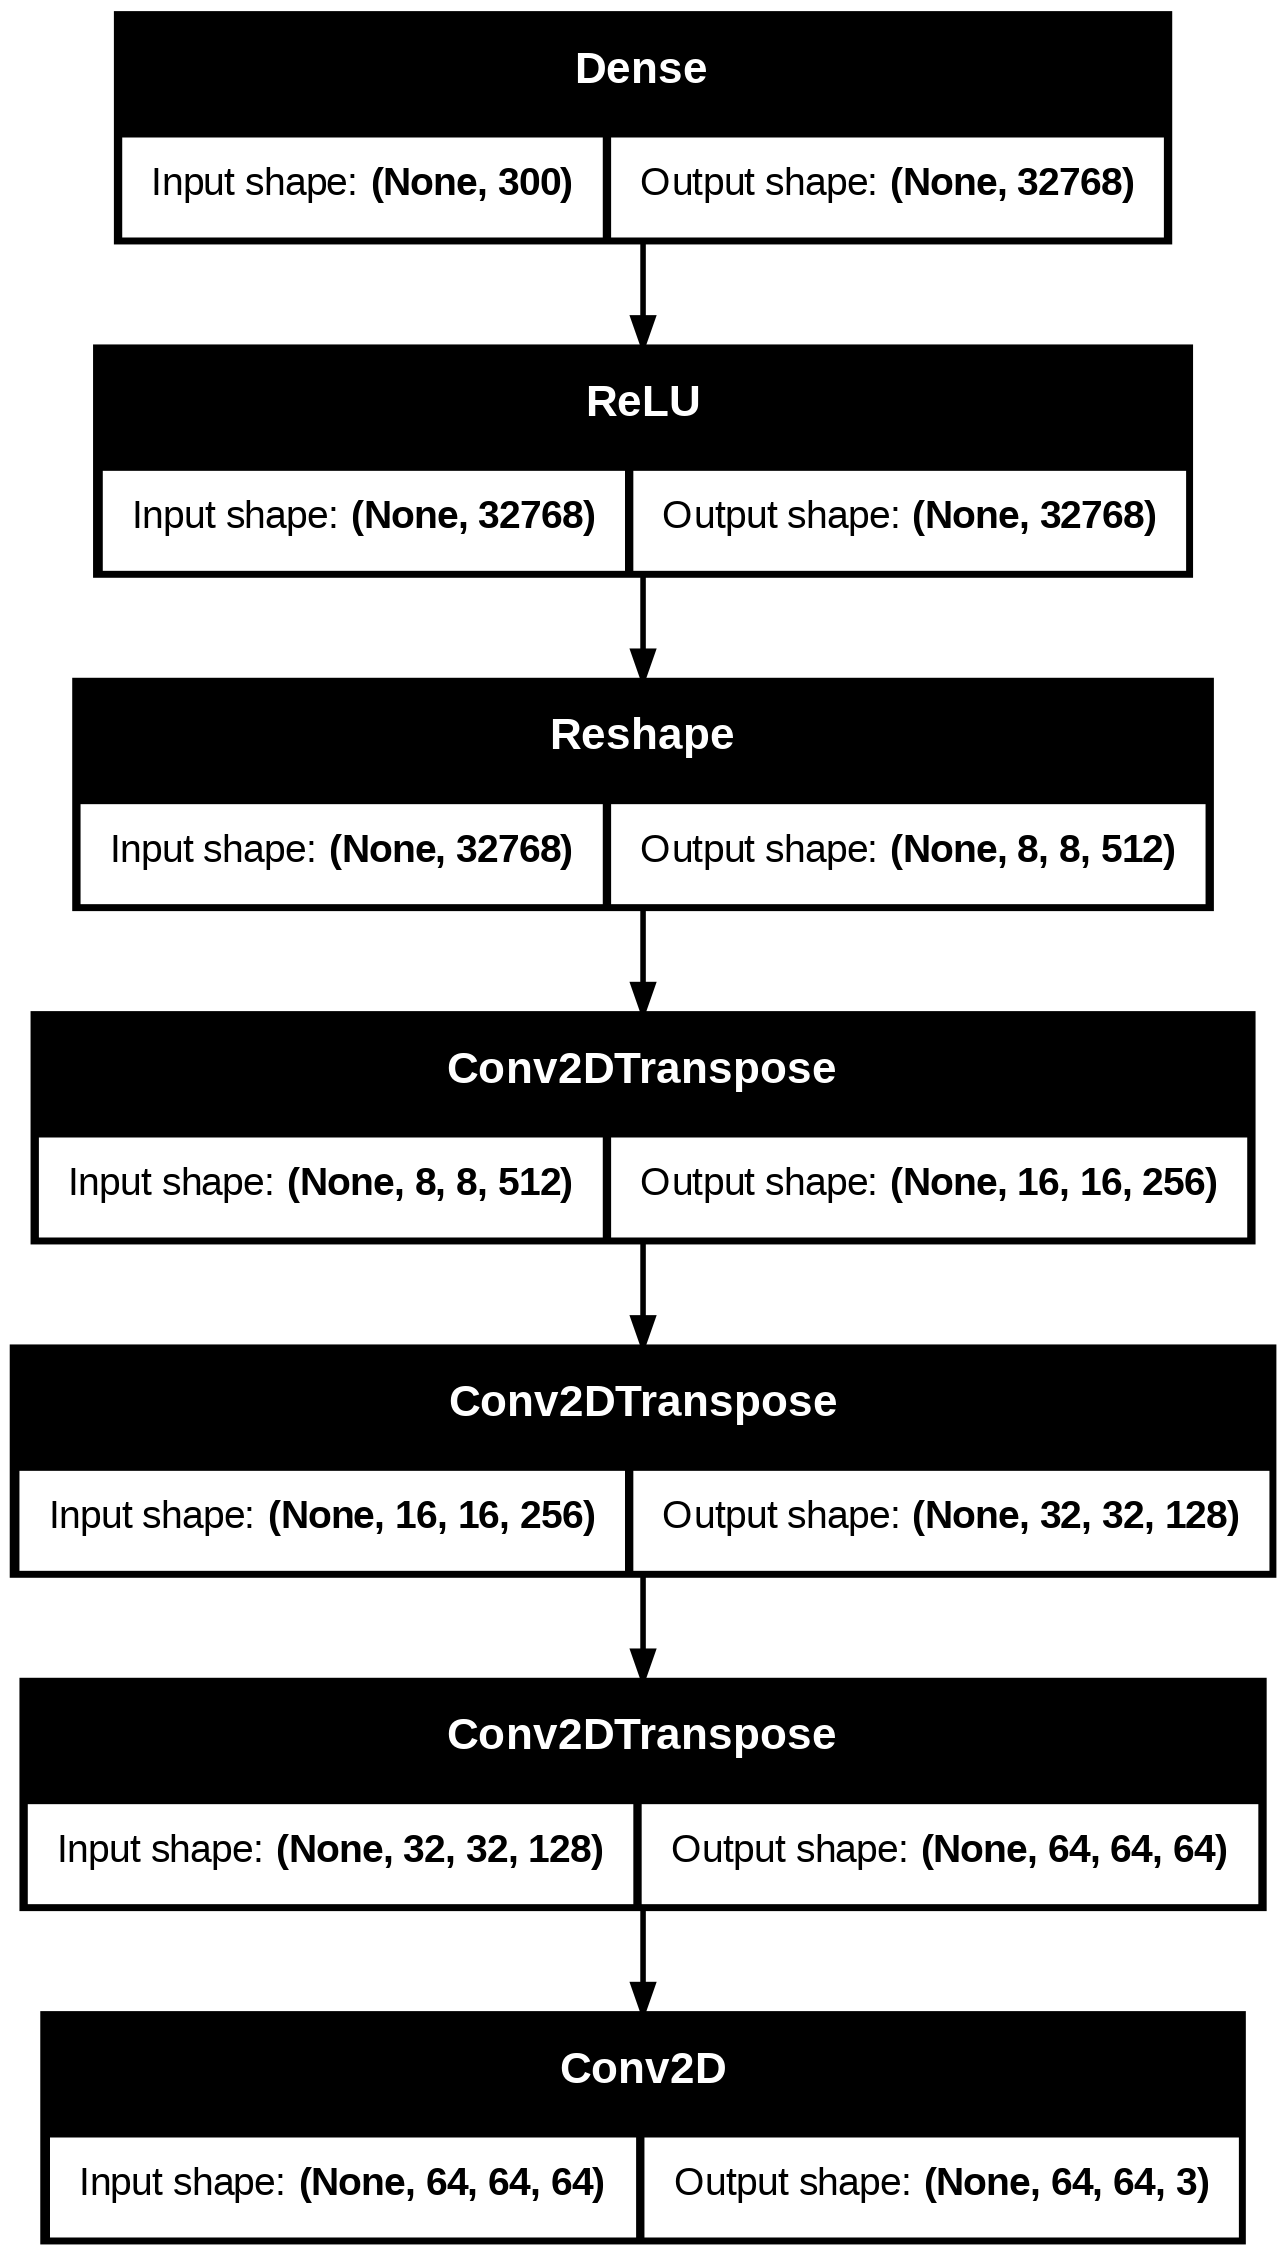

In [32]:
# Creating the Generator Model 

KI = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
input_dim = 300

def Generator_Model():

    Generator = Sequential()

    # Random noise
    Generator.add(Dense(8 * 8 * 512, input_dim = input_dim))
    Generator.add(ReLU())
    # Convert 1d to 3d
    Generator.add(Reshape((8, 8, 512)))
    # Unsample
    Generator.add(Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', kernel_initializer=KI, activation='relu'))
    Generator.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=KI, activation='relu'))
    Generator.add(Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=KI, activation='relu'))
    Generator.add(Conv2D(3, (4, 4), padding='same', activation='sigmoid'))

    
    return Generator
    
generator = Generator_Model()
generator.summary()
# Visualized Layers of generator
keras.utils.plot_model(generator, show_shapes=True)

### The generator

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_17 (Conv2D)                   │ (None, 62, 62, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 29, 29, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 256)                 │       2,359,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,730,625 (10.42 MB)

 Trainable params: 2,730,625 (10.42 MB)

 Non-trainable params: 0 (0.00 B)

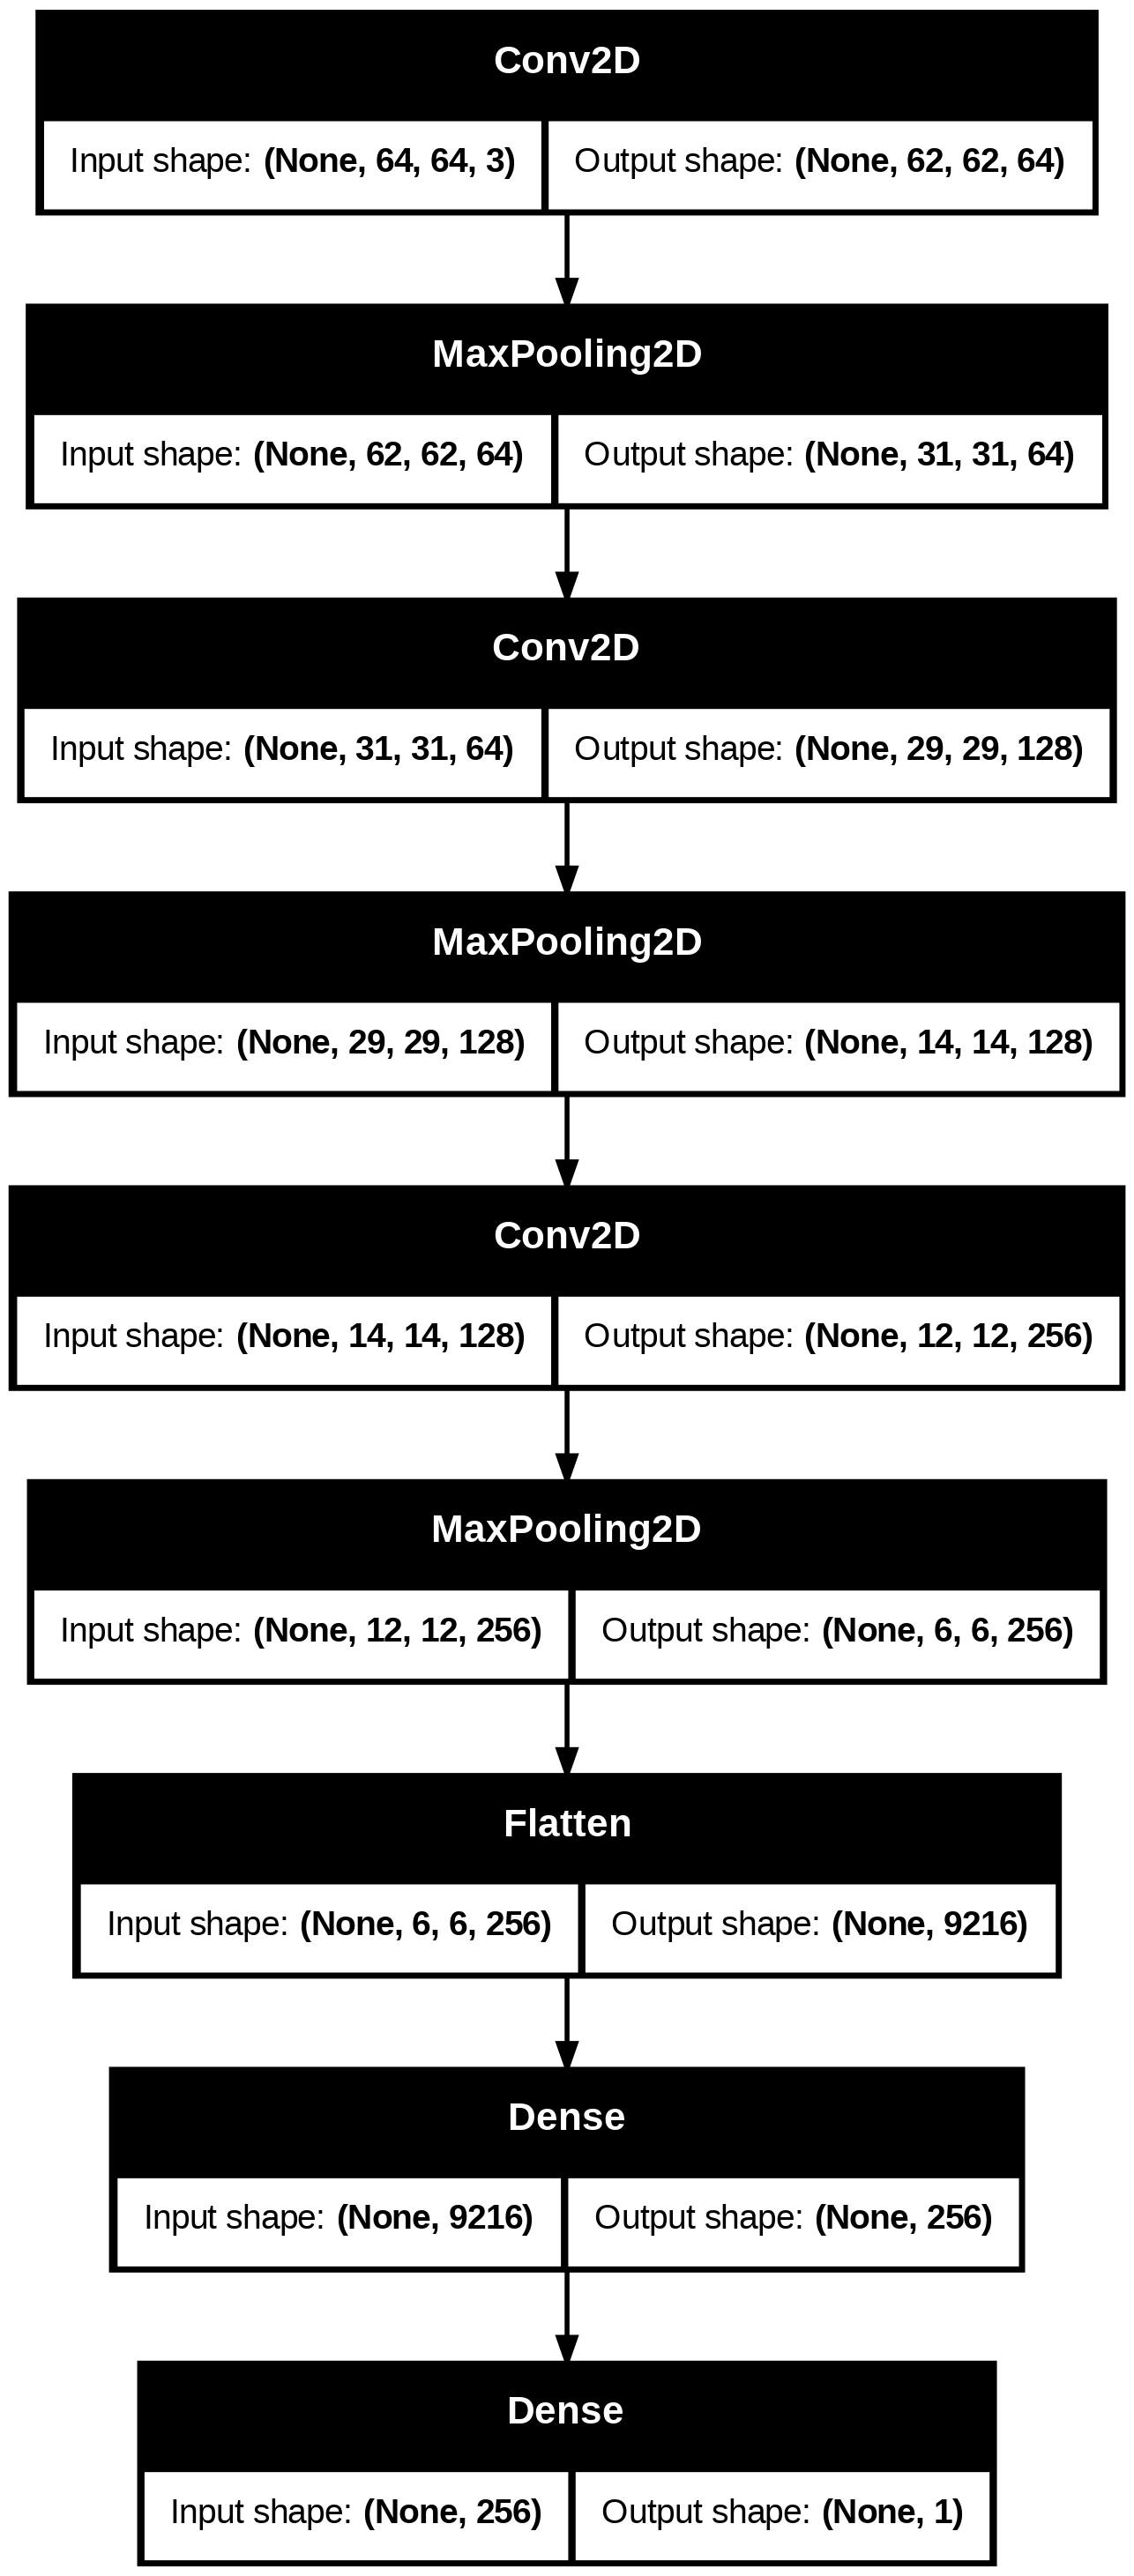

In [33]:
# Creating the discriminator Model 

def Discriminator_Model():
    input_shape = (64, 64, 3)

    # Create a Sequential model
    discriminator = Sequential()
    discriminator.add(Conv2D(64,kernel_size=(3, 3), activation='leaky_relu', input_shape = input_shape))
    discriminator.add(MaxPooling2D(pool_size=(2, 2)))
    discriminator.add(Conv2D(128, kernel_size=(3, 3), activation='leaky_relu'))
    discriminator.add(MaxPooling2D(pool_size=(2, 2)))
    discriminator.add(Conv2D(256, kernel_size=(3, 3), activation='leaky_relu'))
    discriminator.add(MaxPooling2D(pool_size=(2, 2)))
    discriminator.add(Flatten())
    discriminator.add(Dense(256, activation='leaky_relu'))
    discriminator.add(Dense(1, activation='sigmoid'))

    return discriminator

# Training The CNN
discriminator = Discriminator_Model()
discriminator.summary()  
# Visualized Layers of discriminator
keras.utils.plot_model(discriminator, show_shapes=True)

In [34]:
# DCGAN Model Training Step with Discriminator and Generator

class DCGAN(keras.Model):
    def __init__(self, generator, discriminator, latent_dim = input_dim):
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.latent_dim = latent_dim
        self.g_loss_metric = keras.metrics.Mean(name='g_loss')
        self.d_loss_metric = keras.metrics.Mean(name='d_loss')
        
    @property
    def metrics(self):
        return [self.g_loss_metric, self.d_loss_metric]
    
    def compile(self, g_optimizer, d_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        # get batch size from the data
        batch_size = tf.shape(real_images)[0]
        # generate random noise
        random_noise = tf.random.normal(shape=(batch_size, self.latent_dim))
        
        # train the discriminator with real (1) and fake (0) images
        with tf.GradientTape() as tape:
            # compute loss on real images
            pred_real = self.discriminator(real_images, training=True)
            # generate real image labels
            real_labels = tf.ones((batch_size, 1))
            # label smoothing
            real_labels += 0.05 * tf.random.uniform(tf.shape(real_labels))
            d_loss_real = self.loss_fn(real_labels, pred_real)
            
            # compute loss on fake images
            fake_images = self.generator(random_noise)
            pred_fake = self.discriminator(fake_images, training=True)
            # generate fake labels
            fake_labels = tf.zeros((batch_size, 1))
            d_loss_fake = self.loss_fn(fake_labels, pred_fake)
            
            # total discriminator loss
            d_loss = (d_loss_real + d_loss_fake) / 2
            
        # compute discriminator gradients
        gradients = tape.gradient(d_loss, self.discriminator.trainable_variables)
        # update the gradients
        self.d_optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_variables))

        # train the generator model
        labels = tf.ones((batch_size, 1))
        # generator want discriminator to think that fake images are real
        with tf.GradientTape() as tape:
            # generate fake images from generator
            fake_images = self.generator(random_noise, training=True)
            # classify images as real or fake
            pred_fake = self.discriminator(fake_images, training=True)
            # compute loss
            g_loss = self.loss_fn(labels, pred_fake)
            
        # compute gradients
        gradients = tape.gradient(g_loss, self.generator.trainable_variables)
        # update the gradients
        self.g_optimizer.apply_gradients(zip(gradients, self.generator.trainable_variables))
        
        # update states for both models
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        
        return {'d_loss': self.d_loss_metric.result(), 'g_loss': self.g_loss_metric.result()}

In [35]:
# DCGAN Monitor for Image Generation and Model Saving

class DCGANMonitor(keras.callbacks.Callback):
    def __init__(self, num_imgs=25, latent_dim = input_dim):
        self.num_imgs = num_imgs
        self.latent_dim = latent_dim
        # create random noise for generating images
        self.noise = tf.random.normal([25, latent_dim])

    def on_epoch_end(self, epoch, logs = None):
        # generate the image from noise
        g_img = self.model.generator(self.noise)
        # denormalize the image
        g_img = (g_img * 255) + 255
        g_img.numpy()
        
    def on_train_end(self, logs = None):
        self.model.generator.save('DCGEN.h5')

In [36]:
# Training DCGAN on Image Dataset for 40 Epochs

epochs = 30
lr_g =0.0003
lr_d = 0.0001
beta = 0.5
latent_dim = 300

dcgan = DCGAN(generator=generator, discriminator=discriminator, latent_dim = latent_dim )
dcgan.compile(g_optimizer = Adam (learning_rate= lr_g, beta_1= beta), d_optimizer= Adam (learning_rate = lr_d , beta_1= beta), loss_fn = BinaryCrossentropy())

# Fit the model and save the history
history = dcgan.fit(train_generator, epochs=epochs, callbacks=[DCGANMonitor()])

Epoch 1/30
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 75s 33ms/step - d_loss: 0.5713 - g_loss: 1.4257
Epoch 2/30
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 62s 31ms/step - d_loss: 0.5542 - g_loss: 1.3617
Epoch 3/30
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 63s 31ms/step - d_loss: 0.4526 - g_loss: 1.9235
Epoch 4/30
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 62s 31ms/step - d_loss: 0.3765 - g_loss: 2.3284
Epoch 5/30
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 64s 32ms/step - d_loss: 0.3346 - g_loss: 2.5745
Epoch 6/30
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 63s 31ms/step - d_loss: 0.3032 - g_loss: 2.8333
Epoch 7/30
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 64s 32ms/step - d_loss: 0.2853 - g_loss: 2.9808
Epoch 8/30
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 68s 34ms/step - d_loss: 0.2408 - g_loss: 3.1690
Epoch 9/30
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 66s 33ms/step - d_loss: 0.2317 - g_loss: 3.3320
Epoch 10/30
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 70s 35ms/step - d_loss: 0.2373 - g_loss: 3.3243
Epoch 11/30
1987/1987 ━━━━━━━━━━━━━━━━━━━━ 72s 36ms/step - d_loss: 0.2337 - g_loss: 3.3507
Epoch 12

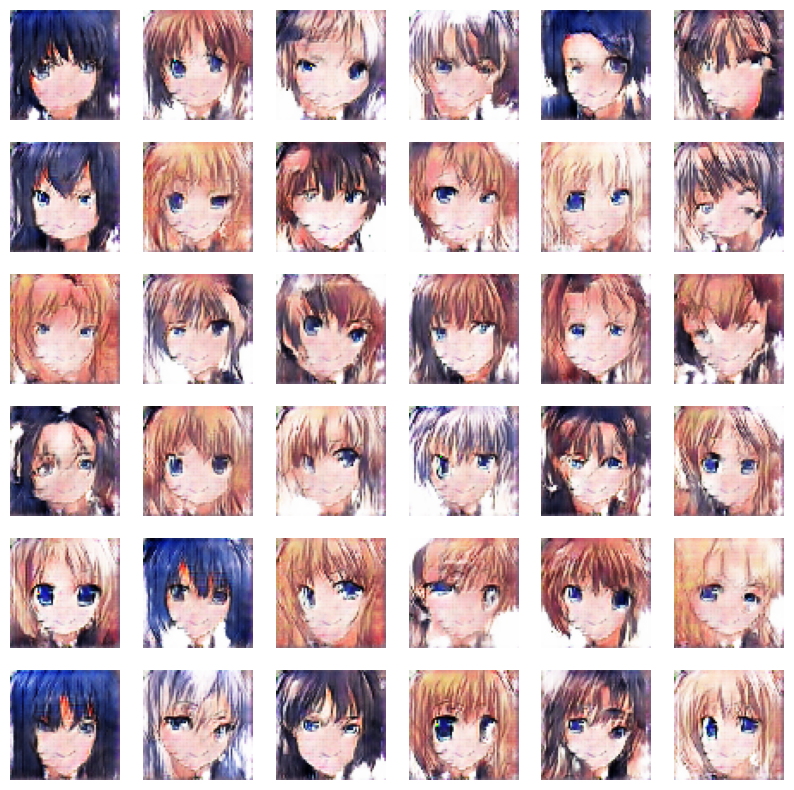

In [37]:
# Generating 36 Random Images with DCGAN

plt.figure(figsize=(10, 10))

for i in range(36):
    plt.subplot(6, 6, i + 1)
    # Generate random noise for each image
    noise = tf.random.normal([1, 300])
    mg = dcgan.generator(noise)
    # Denormalize
    mg = (mg * 255) + 255

    mg.numpy()
    image = Image.fromarray(np.uint8(mg[0]))

    plt.imshow(image)
    plt.axis('off')

plt.show()

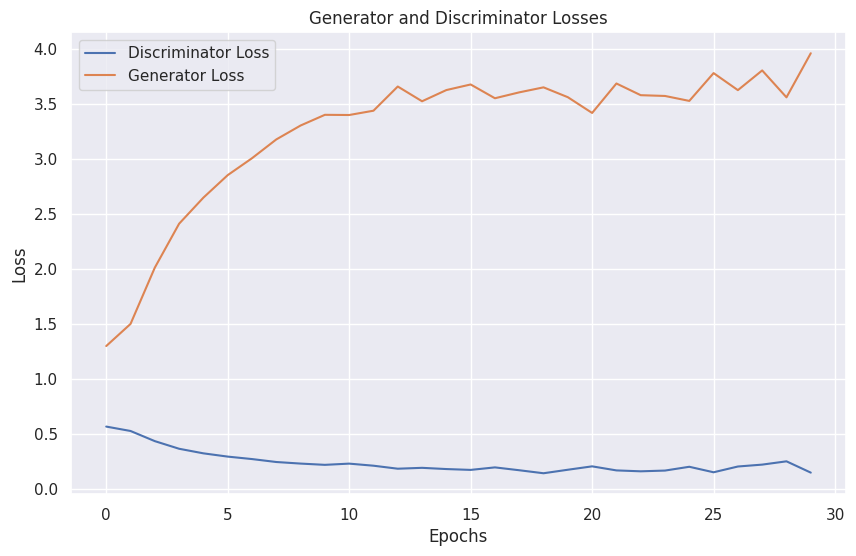

In [38]:
import matplotlib.pyplot as plt

# Function to create a figure for the losses
def create_loss_figure(d_loss_values, g_loss_values):
    plt.figure(figsize=(10, 6))
    plt.plot(d_loss_values, label='Discriminator Loss')
    plt.plot(g_loss_values, label='Generator Loss')
    plt.title('Generator and Discriminator Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Access the loss values from the history
d_loss_values = history.history['d_loss']
g_loss_values = history.history['g_loss']

# Call the create_loss_figure function with the loss values
create_loss_figure(d_loss_values, g_loss_values)